In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sqlite3
import numpy as np
from SlideRunner.dataAccess.database import Database
from tqdm import tqdm
from pathlib import Path
import openslide
import time
import pickle
import cv2

In [4]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.data_block import *

In [68]:
import matplotlib
matplotlib.colors.to_rgb('m')

(0.75, 0.0, 0.75)

In [5]:
import matplotlib.pyplot as plt

In [6]:
from helper.nms_center_distance import non_max_suppression_by_distance

In [7]:
def draw_rects(bboxes, labels, axis):
    for box, label in zip(bboxes, labels):
        colors = ['b', 'g', 'r', 'c', 'm']

        patch = axis.add_patch(
            patches.Rectangle((box[1], box[0]), width=box[3] - box[1], height=box[2] - box[0], fill=False,
                              edgecolor=colors[label], lw=2))

In [8]:
path = Path('/data/Datasets/EIPH_WSI/')

In [9]:
database = Database()
database.open(str(path/'EIPH.sqlite'))

True

In [10]:
files = []
lbl_bbox = []

getslides = """SELECT uid, filename FROM Slides"""
for currslide, filename in tqdm(database.execute(getslides).fetchall()):
    database.loadIntoMemory(currslide)

    check = True if 'erliner' in filename else False
    slidetype = 'Berliner Blau/' if check else 'Turnbull Blue/'

    slide_path = path / slidetype / filename

    down_factor = 1

    classes = {3: 0, 4: 1, 5: 2, 6: 3, 7: 4}#{3: 1, 4: 2, 5: 3, 6: 4, 7: 5} #
    labels, bboxes = [], []
    for id, annotation in database.annotations.items():
        if annotation.labels[0].classId in classes:
            d = 2 * annotation.r / down_factor
            x_min = (annotation.x1 - annotation.r) / down_factor
            y_min = (annotation.y1 - annotation.r) / down_factor
            x_max = x_min + d
            y_max = y_min + d
            label = classes[annotation.labels[0].classId]

            bboxes.append([int(x_min), int(y_min), int(x_max), int(y_max)])
            labels.append(label)

    if len(bboxes) > 0:
        lbl_bbox.append([bboxes, labels])
        files.append(slide_path)

img2bbox = dict(zip(files, np.array(lbl_bbox)))
get_y_func = lambda o:img2bbox[o]

  0%|          | 0/24 [00:00<?, ?it/s]

Loading DB into memory ...


  4%|▍         | 1/24 [00:00<00:06,  3.39it/s]

Loading DB into memory ...


  8%|▊         | 2/24 [00:01<00:13,  1.64it/s]

Loading DB into memory ...


 12%|█▎        | 3/24 [00:02<00:12,  1.75it/s]

Loading DB into memory ...


 21%|██        | 5/24 [00:02<00:07,  2.44it/s]

Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...


 29%|██▉       | 7/24 [00:03<00:05,  2.87it/s]

Loading DB into memory ...


 38%|███▊      | 9/24 [00:03<00:03,  3.94it/s]

Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...


 46%|████▌     | 11/24 [00:03<00:02,  4.99it/s]

Loading DB into memory ...


 50%|█████     | 12/24 [00:03<00:02,  4.38it/s]

Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...


 71%|███████   | 17/24 [00:04<00:01,  5.13it/s]

Loading DB into memory ...
Loading DB into memory ...


 79%|███████▉  | 19/24 [00:04<00:00,  6.28it/s]

Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...


 88%|████████▊ | 21/24 [00:05<00:00,  5.22it/s]

Loading DB into memory ...
Loading DB into memory ...


100%|██████████| 24/24 [00:06<00:00,  3.79it/s]

Loading DB into memory ...


In [19]:
def getIDs(bboxes, labels,x,y,h,w):
    bboxes = np.array(bboxes)
    labels = np.array(labels)

    bboxes[:, [0, 2]] = bboxes[:, [0, 2]] - x
    bboxes[:, [1, 3]] = bboxes[:, [1, 3]] - y

    bb_widths = (bboxes[:, 2] - bboxes[:, 0]) / 2
    bb_heights = (bboxes[:, 3] - bboxes[:, 1]) / 2

    ids = ((bboxes[:, 0] + bb_widths) > 0) & ((bboxes[:, 1] + bb_heights) > 0) & ((bboxes[:, 2] - bb_widths) < w) & ((bboxes[:, 3] - bb_heights) < h)
    
    return ids  

In [59]:
def get_ImageBBox(bboxes, labels,x,y,h,w):
    bboxes = np.array(bboxes)
    labels = np.array(labels)

    bboxes[:, [0, 2]] = bboxes[:, [0, 2]] - x
    bboxes[:, [1, 3]] = bboxes[:, [1, 3]] - y

    bb_widths = (bboxes[:, 2] - bboxes[:, 0]) / 2
    bb_heights = (bboxes[:, 3] - bboxes[:, 1]) / 2

    ids = ((bboxes[:, 0] + bb_widths) > 0) & ((bboxes[:, 1] + bb_heights) > 0) & ((bboxes[:, 2] - bb_widths) < w) & ((bboxes[:, 3] - bb_heights) < h)
        
    bboxes = bboxes[ids]
    bboxes = np.clip(bboxes, 0, x)
    bboxes = bboxes[:, [1, 0, 3, 2]]

    labels = labels[ids]
    return bboxes,  labels

In [60]:
def create_results(axis, annotations_temp, labels_temp, x, y, height, width, threshold = 0.3):
    #ids = annotations_temp[:, 5] > threshold
    
    bboxes = annotations_temp[:, :4]
    labels_temp = labels_temp.astype(int)
    bboxes, labels = get_ImageBBox(bboxes, labels_temp, x, y, height, width)
    
    #print(bboxes)
    return draw_rects(bboxes, labels, axis)

In [13]:
resultsArchive = pickle.load(open('inference_results_boxes_all.p','rb'))

In [14]:
files

[PosixPath('/data/Datasets/EIPH_WSI/Berliner Blau/01_EIPH_563479 Berliner Blau.svs'),
 PosixPath('/data/Datasets/EIPH_WSI/Berliner Blau/02_EIPH_574162 berliner blau.svs'),
 PosixPath('/data/Datasets/EIPH_WSI/Berliner Blau/03_EIPH_566933 R Berliner Blau neu.svs'),
 PosixPath('/data/Datasets/EIPH_WSI/Berliner Blau/04_EIPH_567017 Berliner Blau.svs'),
 PosixPath('/data/Datasets/EIPH_WSI/Berliner Blau/05_EIPH_569923 Berliner Blau.svs'),
 PosixPath('/data/Datasets/EIPH_WSI/Berliner Blau/27_EIPH_571557 berliner blau.svs'),
 PosixPath('/data/Datasets/EIPH_WSI/Berliner Blau/31_EIPH_568354 Berliner Blau.svs'),
 PosixPath('/data/Datasets/EIPH_WSI/Berliner Blau/11_EIPH_575697 Berliner Blau.svs'),
 PosixPath('/data/Datasets/EIPH_WSI/Turnbull Blue/29_EIPH_566481 L Turnbull blue.svs'),
 PosixPath('/data/Datasets/EIPH_WSI/Turnbull Blue/28_EIPH_569948 L Turnbull blue.svs'),
 PosixPath('/data/Datasets/EIPH_WSI/Turnbull Blue/14_EIPH_568381 Turnbull blue.svs'),
 PosixPath('/data/Datasets/EIPH_WSI/Berliner

In [14]:
file = [f for f in files if "22_EIPH_575216 Turnbull blue" in str(f)][0]

slide = openslide.open_slide(str(file))

file

PosixPath('/data/Datasets/EIPH_WSI/Turnbull Blue/22_EIPH_575216 Turnbull blue.svs')

In [15]:
boxes_gt, labels_gt = get_y_func(file)
boxes_gt, labels_gt = np.array(boxes_gt), np.array(labels_gt)
#boxes_gt[:, 2:] = boxes_gt[:, 2:] - boxes_gt[:, :2]
    
annotations = np.array(resultsArchive[file.stem+".svs"])
    
annotations_nms_dist = non_max_suppression_by_distance(annotations, annotations[:, 5], radius=50)

In [70]:
x = 4500#26525  4000, 10000
y = 7500#21036
width = 1024
height = 1024

image_np = np.array(slide.read_region(location=(x,y),
                                          level=0, size=(width, height)))[:, :, :3]

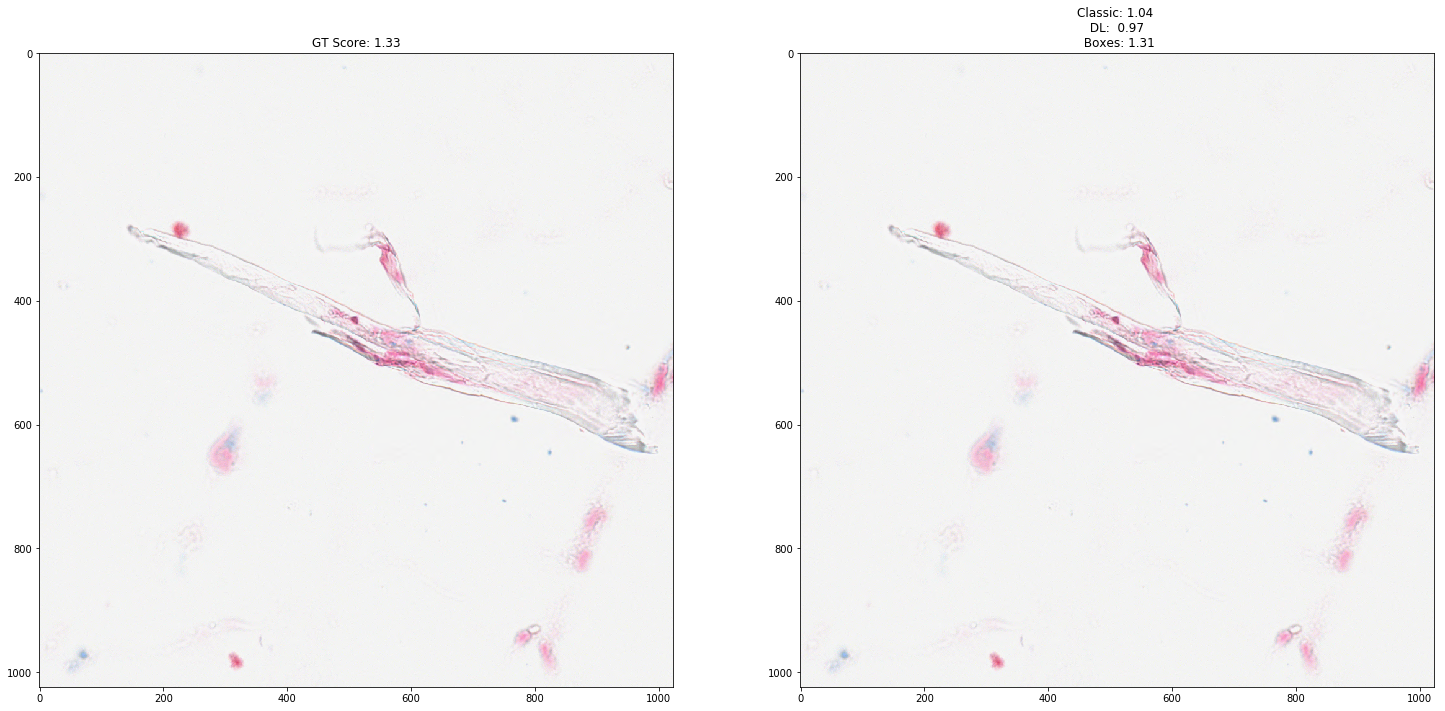

In [74]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(25,25))

ax1.set_title("GT Score: {0:1.2f}".format(np.mean(labels_gt)))
create_results(ax1, boxes_gt, labels_gt, x, y, height, width)
ax1.imshow(image_np)

ids = annotations_nms_dist[:, 5] > 0.6
ax2.set_title("Classic: {0:1.2f} \n DL:  {1:1.2f} \n Boxes: {2:1.2f}".format(1.04, 0.97, np.mean(annotations_nms_dist[ids, 4])))
create_results(ax2, annotations_nms_dist[ids], annotations_nms_dist[ids, 4], x, y, height, width)
ax2.imshow(image_np)

plt.rcParams["font.family"] = "Times New Roman"
#plt.rcParams['svg.fonttype'] = 'none'
fig.savefig(file.stem+"_{0}_{1}_.svg".format(x,y), transparent=True)

In [49]:
file.stem+"_{0}_{1}_.svg".format(x,y)

'22_EIPH_575216 Turnbull blue_26195_22947_.svg'

In [18]:
ids

array([ True,  True,  True,  True, ..., False, False, False, False])

In [24]:
annotation_ids

array([False, False, False, False, ..., False, False, False, False])

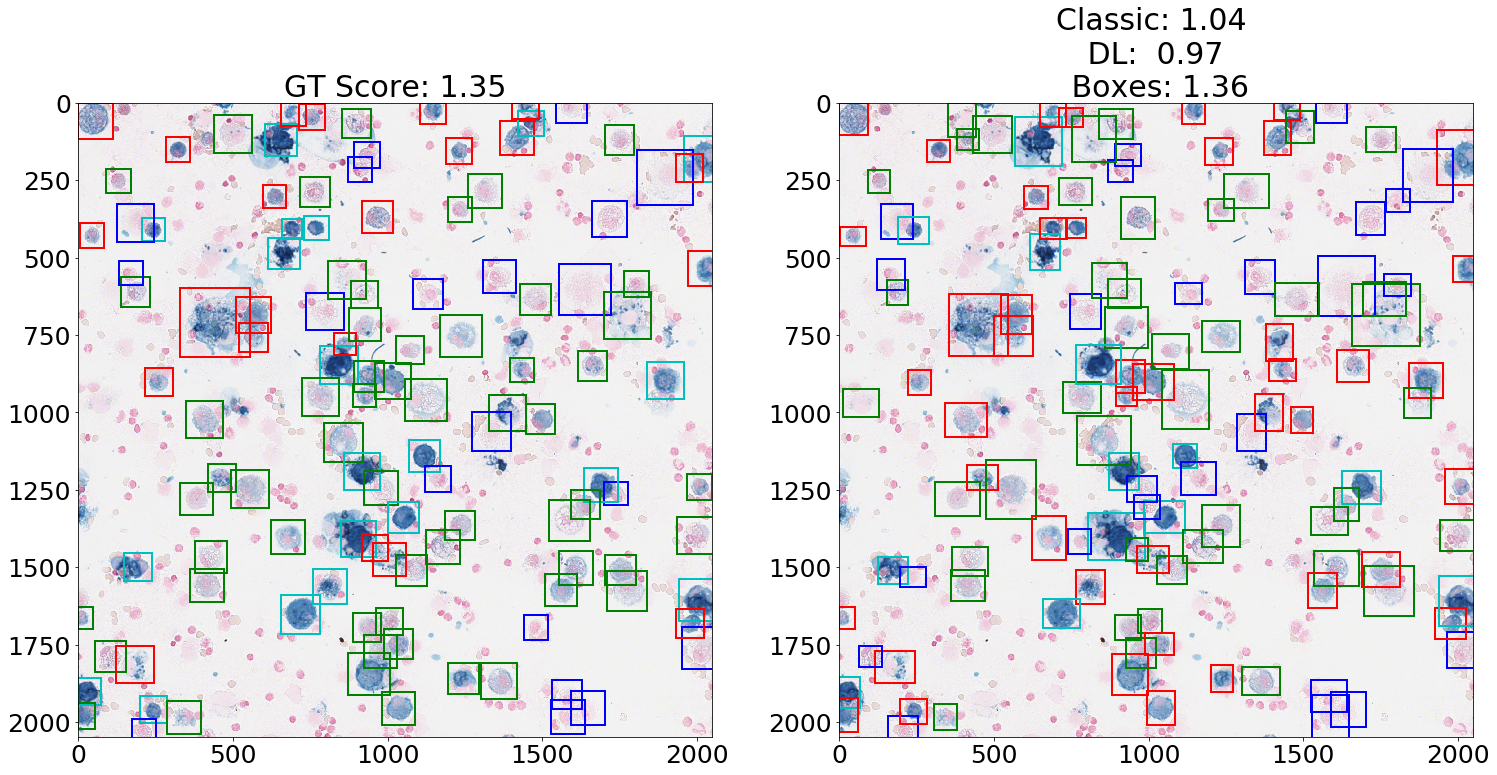

In [62]:
plt.rcParams["font.size"] = 25

x = 26525#26525  4000, 10000
y = 21036#21036
w = width = 2048
h = height = 2048

image_np = np.array(slide.read_region(location=(x,y),
                                          level=0, size=(width, height)))[:, :, :3]


fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(25,25))


gt_ids = getIDs(boxes_gt, labels_gt,x,y,h,w)
annotation_ids = getIDs(annotations_nms_dist.copy(), annotations_nms_dist[:, 4].copy(),x,y,h,w)
rect_boxes = annotations_nms_dist[annotation_ids]
mean = np.mean(rect_boxes[rect_boxes[:, 5] > 0.5, 4])

ax1.set_title("GT Score: {0:1.2f}".format(np.mean(labels_gt[gt_ids])))
create_results(ax1, boxes_gt, labels_gt, x, y, height, width)
ax1.imshow(image_np)

ids = annotations_nms_dist[:, 5] > 0.5
ax2.set_title("Classic: {0:1.2f} \n DL:  {1:1.2f} \n Boxes: {2:1.2f}".format(1.04, 0.97, mean))
create_results(ax2, annotations_nms_dist[ids], annotations_nms_dist[ids, 4], x, y, height, width)
ax2.imshow(image_np)

plt.rcParams["font.family"] = "Times New Roman"
#plt.rcParams['svg.fonttype'] = 'none'
fig.savefig(file.stem+"_{0}_{1}_.pdf".format(x,y), transparent=True)

In [56]:
len(annotations_nms_dist)

13288

In [46]:
rect_boxes = annotations_nms_dist[annotation_ids]
rect_boxes

array([[2.776900e+04, 2.126500e+04, 2.791300e+04, 2.137700e+04, 1.000000e+00, 8.665547e-01, 1.003854e+00],
       [2.807100e+04, 2.152900e+04, 2.825500e+04, 2.172300e+04, 0.000000e+00, 8.449333e-01, 1.031402e+00],
       [2.741700e+04, 2.269000e+04, 2.750200e+04, 2.277000e+04, 1.000000e+00, 8.407732e-01, 1.725875e+00],
       [2.782600e+04, 2.285900e+04, 2.794900e+04, 2.295000e+04, 1.000000e+00, 8.348572e-01, 1.554685e+00],
       ...,
       [2.817300e+04, 2.158700e+04, 2.827800e+04, 2.170300e+04, 0.000000e+00, 1.122858e-01, 1.538664e+00],
       [2.790000e+04, 2.133200e+04, 2.800700e+04, 2.145100e+04, 1.000000e+00, 1.103176e-01, 8.198965e-01],
       [2.757700e+04, 2.298600e+04, 2.766300e+04, 2.308300e+04, 0.000000e+00, 1.099461e-01, 1.853571e+00],
       [2.662100e+04, 2.178900e+04, 2.672500e+04, 2.186800e+04, 0.000000e+00, 1.003148e-01, 3.602687e-01]])

In [51]:
np.mean(rect_boxes[rect_boxes[:, 5] > 0.5, 4])

1.3571428571428572

In [36]:
len(annotation_ids)

13288